# Your company is Rossmann.
### Business issue : predict the stores turnover

Authors: BOIVIN Jolyanne, BOUCHER Axel, DE BROGLIE Aymon, GRIGNARD Jeremy, KARTHIGESU Dinojan, NAULET Antoine

### Table of contents

* Preprocessing
* Feature Engineering
* Validation strategy
* Training and evaluation

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt

# For split
from sklearn.model_selection import train_test_split
%matplotlib inline

# Data Loading

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')

/home/aymon/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
5,6,10,4,2015-09-17,1.0,1,0,0
6,7,11,4,2015-09-17,1.0,1,0,0
7,8,12,4,2015-09-17,1.0,1,0,0
8,9,13,4,2015-09-17,1.0,1,0,0
9,10,14,4,2015-09-17,1.0,1,0,0


In [5]:
distinctIdStoreTest = test.Id.unique()
distinctIdStoreTest

array([    1,     2,     3, ..., 41086, 41087, 41088])

In [6]:
test[test.Store == 3].sort_values(by='Date', ascending=True)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
40233,40234,3,6,2015-08-01,1.0,0,0,0
39377,39378,3,7,2015-08-02,0.0,0,0,0
38521,38522,3,1,2015-08-03,1.0,1,0,1
37665,37666,3,2,2015-08-04,1.0,1,0,1
36809,36810,3,3,2015-08-05,1.0,1,0,1
35953,35954,3,4,2015-08-06,1.0,1,0,1
35097,35098,3,5,2015-08-07,1.0,1,0,1
34241,34242,3,6,2015-08-08,1.0,0,0,0
33385,33386,3,7,2015-08-09,0.0,0,0,0
32529,32530,3,1,2015-08-10,1.0,0,0,1


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# First Look 

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [10]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
print('Here we can see that there are missing values for several features in store:', store.isnull().sum().sum())

Here we can see that there are missing values for several features in store: 2343


# Preprocessing

## Preprocessing on Train and Test

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


#### According to the documentation

* DateTime for Date
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


### Change the date to hundle datetime object

In [14]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

### We first replace the '0' values present in the train and test set by 0 (int) Next we use get dummies for each present value

In [15]:
print("Train before", train['StateHoliday'].unique())
train.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Train Before", train['StateHoliday'].unique())

Train before ['0' 'a' 'b' 'c' 0]
Train Before [0 'a' 'b' 'c']


In [16]:
print("Test After", test['StateHoliday'].unique())
test.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Test After", test['StateHoliday'].unique())

Test After ['0' 'a']
Test After [0 'a']


In [17]:
train[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']] = pd.get_dummies(train['StateHoliday'])
test[['StateHoliday_0', 'StateHoliday_a']] = pd.get_dummies(test['StateHoliday'])
train.drop('StateHoliday', axis=1, inplace=True)
test.drop('StateHoliday', axis=1, inplace=True)

### Here we check the DayOfWeek for each Nan Values for the feature Open
#### As we can see, there is no Sunday. Therefore we replace the NaN values by 1 (the store is open), To be more realistic we should map the day with a American calendar to see if each day is a sunday, special day, close day, holiday, public bank holiday

In [18]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a
479,480,622,4,2015-09-17,NaN,1,0,1,0
1335,1336,622,3,2015-09-16,NaN,1,0,1,0
2191,2192,622,2,2015-09-15,NaN,1,0,1,0
3047,3048,622,1,2015-09-14,NaN,1,0,1,0
4759,4760,622,6,2015-09-12,NaN,0,0,1,0
5615,5616,622,5,2015-09-11,NaN,0,0,1,0
6471,6472,622,4,2015-09-10,NaN,0,0,1,0
7327,7328,622,3,2015-09-09,NaN,0,0,1,0
8183,8184,622,2,2015-09-08,NaN,0,0,1,0
9039,9040,622,1,2015-09-07,NaN,0,0,1,0


In [19]:
test.replace({"Open": {np.nan: 1}}, inplace=True)

In [20]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a


## Preprocessing on Store

In [21]:
objectFeaturesStore = ['StoreType', 'Assortment', 'PromoInterval']

In [22]:
store[objectFeaturesStore].head()

,StoreType,Assortment,PromoInterval
0,c,a,NaN
1,a,a,"Jan,Apr,Jul,Oct"
2,a,a,"Jan,Apr,Jul,Oct"
3,c,c,NaN
4,a,a,NaN


According to the documentation

* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


#### Replace missing values by mean 

In [23]:
# Features to preprecess numerically
# 3 features are object type
featuresToPreprocessByMean = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear']

In [24]:
for idx in featuresToPreprocessByMean:
    store[idx] = store[idx].fillna(np.mean(store[idx]))

In [25]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### StoreType, Assortment, PromoInterval

In [26]:
print('distinct_storeType:', store['StoreType'].unique(), '\ndistinct_assortment: ', store['Assortment'].unique(), '\ndistinct_promoInterval: ', store['PromoInterval'].unique())

distinct_storeType: ['c' 'a' 'd' 'b'] 
distinct_assortment:  ['a' 'c' 'b'] 
distinct_promoInterval:  [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [27]:
store[['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']] = pd.get_dummies(store['StoreType'])
store[['Assortment_a', 'Assortment_b', 'Assortment_c']] = pd.get_dummies(store['Assortment'])
store.drop('StoreType', axis=1, inplace=True)
store.drop('Assortment', axis=1, inplace=True)

In [28]:
store.replace({"PromoInterval": {np.nan: 0}}, inplace=True)

In [29]:
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,1,0,1,0,0
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,1,0,0,0,1
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,0,0,1,0,0


In [30]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 15 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
dtypes: float64(5), int64(2), object(1), uint8(7)
memory usage: 77.4+ KB


In [31]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
promoMonths = ['PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr', 'PromoMay', 'PromoJun', 'PromoJul', 
               'PromoAug', 'PromoSept', 'PromoOct', 'PromoNov', 'PromoDec']

# Ajout des colonnes pour tous les moisPromo
# On mettra 1 qd promo, 0 sinon
for v in promoMonths:
    store[v] = 0
    
for idx, val in enumerate(store['PromoInterval']):
    if val != 0:
        mons = val.split(',')
        for mon in mons:
            columnName = 'Promo' + mon
            store.loc[idx, columnName] = 1


In [32]:
##On rajoute une colonne pour avoir la data du début de la competition ainsi qu'une date du début de promo 2
def date_init_compet (col1, col2):
    if col1 != 0:
        return pd.to_datetime(str('01/')+str((int(col1)))+"/"+str(int(col2)))
    
def date_init_promo(week,year):
    if week != 0: 
        return pd.to_datetime(str(int(week)) + '/' + str(int(year)) + '/' + '0', format='%W/%Y/%w')
    
store['BeginCompetition'] = store.apply(lambda x : date_init_compet(x['CompetitionOpenSinceMonth'], x['CompetitionOpenSinceYear']),axis=1) 
store['BeginPromo2'] = store.apply(lambda x : date_init_promo(x['Promo2SinceWeek'], x['Promo2SinceYear']),axis=1) 

    
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,...,0,0,1,0,0,1,0,0,2007-01-11,2010-04-04
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,...,0,0,1,0,0,1,0,0,2006-01-12,2011-04-10
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,...,0,0,0,0,0,0,0,0,2009-01-09,2011-06-12
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,...,0,0,0,0,0,0,0,0,2015-01-04,2011-06-12


In [33]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 29 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
PromoJan                     1115 non-null int64
PromoFeb                     1115 non-null int64
PromoMar                     1115 non-null int64


#### Merge Train and Store

In [34]:
train.columns, store.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
        'StateHoliday_c'],
       dtype='object'),
 Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
        'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
        'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
        'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
        'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2'],
       dtype='object'))

In [35]:
df = pd.merge(train, store, left_on='Store', right_on='Store')

In [36]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 40 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
SchoolHoliday                1017209 non-null int64
StateHoliday_0               1017209 non-null uint8
StateHoliday_a               1017209 non-null uint8
StateHoliday_b               1017209 non-null uint8
StateHoliday_c               1017209 non-null uint8
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non

In [38]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,PromoMar,PromoApr,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,9.694753e-01,1.991724e-02,6.576820e-03,...,9.581119e-02,2.881630e-01,1.165896e-01,9.581119e-02,2.881630e-01,1.165896e-01,9.581119e-02,2.881630e-01,1.165896e-01,9.581119e-02
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,1.720261e-01,1.397160e-01,8.083051e-02,...,2.943323e-01,4.529076e-01,3.209308e-01,2.943323e-01,4.529076e-01,3.209308e-01,2.943323e-01,4.529076e-01,3.209308e-01,2.943323e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [39]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
5,1,7,2015-07-26,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
6,1,6,2015-07-25,4364,500,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
7,1,5,2015-07-24,3706,459,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
8,1,4,2015-07-23,3769,503,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
9,1,3,2015-07-22,3464,463,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12


### Merge Test et Store

In [40]:
test.columns, store.columns

(Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday',
        'StateHoliday_0', 'StateHoliday_a'],
       dtype='object'),
 Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
        'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
        'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
        'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
        'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2'],
       dtype='object'))

In [41]:
df_test = pd.merge(test, store, left_on='Store', right_on='Store')

In [42]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,CompetitionDistance,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,1,4,2015-09-17,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,857,1,3,2015-09-16,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
2,1713,1,2,2015-09-15,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
3,2569,1,1,2015-09-14,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
4,3425,1,7,2015-09-13,0.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 37 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
SchoolHoliday                41088 non-null int64
StateHoliday_0               41088 non-null uint8
StateHoliday_a               41088 non-null uint8
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
StoreType_a                  41088 non-null uint8
StoreType_b        

In [44]:
df_test

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,CompetitionDistance,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,1,4,2015-09-17,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,857,1,3,2015-09-16,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
2,1713,1,2,2015-09-15,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
3,2569,1,1,2015-09-14,1.0,1,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
4,3425,1,7,2015-09-13,0.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
5,4281,1,6,2015-09-12,1.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
6,5137,1,5,2015-09-11,1.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
7,5993,1,4,2015-09-10,1.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
8,6849,1,3,2015-09-09,1.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
9,7705,1,2,2015-09-08,1.0,0,0,1,0,1270.0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12


# Feature Engineering

## Code Antoine et Generator
### UTILISER LE GENERATOR POUR AJOUTER DES FEATURES :)

In [51]:
  def create_promo2(promo, curr_date,begin_date, interval ):
        list_mois = ['Jan','Feb','Mar', 'Apr','May','Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov','Dec']
        if promo  and (curr_date > begin_date) and (list_mois[curr_date.month -1 ] in interval.split(',')):
            return 1 
        else:
            return 0 

In [52]:
def generator (df) :
    # produit les elements exploitables : date de reference en format date, toute les en autres en distance 
    # de la reference
    # exploite les donnees de promo2 pour savoir a chaque entree si le magasin est en promo2
    # retourne les elements caracteristiques de la date actuelle

    df['duree_concurence']= (df['Date'] - pd.to_datetime(df['BeginCompetition'])).dt.days
    df['promo2_today'] =df.apply( lambda x : create_promo2(x['Promo2'],x['Date'], x['BeginPromo2'] , x['PromoInterval']),axis = 1 )
    df['year']=df['Date'].apply(lambda x: x.year)
    df['month']=df['Date'].apply(lambda x: x.month)
    df['day']=df['Date'].apply(lambda x: x.day)
    df['dayofyear']=df['Date'].apply(lambda x: x.dayofyear)
    df['weekofyear']=df['Date'].apply(lambda x: x.weekofyear)
    df['dayofweek']=df['Date'].apply(lambda x: x.dayofweek)
    df['quarter']=df['Date'].apply(lambda x: x.quarter)
    
    df['duree_promo2'] = (df['Date'] - df['BeginPromo2']).dt.days

    return (df)

Fonction qui parcourt les données et va chercher si il y a le jour de l'année d'avant 

In [53]:
def old_year(df, givenYear, givenMonth, givenDay):
    for idx in range(df.shape[0]):
        if(df['year'][idx] == givenYear - 1 and df['month'][idx] == givenMonth and df['day'][idx] == givenDay):
            return df.iloc[idx]

    return None  

In [48]:
testingfunction = old_year(df, 2014, 1, 6)
print(testingfunction)

KeyError: 'year'

# Validation strategy

In [54]:
df = generator(df)
df_test = generator(df_test)

In [55]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,2760,0,2015,7,31,212,31,4,3,1510
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,2759,0,2015,7,30,211,31,3,3,1509
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,2758,0,2015,7,29,210,31,2,3,1508
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,2757,0,2015,7,28,209,31,1,3,1507
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,2756,0,2015,7,27,208,31,0,3,1506
5,1,7,2015-07-26,0,0,0,0,0,1,0,...,2755,0,2015,7,26,207,30,6,3,1505
6,1,6,2015-07-25,4364,500,1,0,0,1,0,...,2754,0,2015,7,25,206,30,5,3,1504
7,1,5,2015-07-24,3706,459,1,0,0,1,0,...,2753,0,2015,7,24,205,30,4,3,1503
8,1,4,2015-07-23,3769,503,1,0,0,1,0,...,2752,0,2015,7,23,204,30,3,3,1502
9,1,3,2015-07-22,3464,463,1,0,0,1,0,...,2751,0,2015,7,22,203,30,2,3,1501


##### Split into train and validation set

In [ ]:
### WARNING: Je prends beaucoup moins de data pour faire tourner l'ensemble du notebook dans un premier temps
#df = df.head(10000)

In [56]:
Train, Validation = train_test_split(df, test_size=0.3)

In [57]:
Train.shape, Validation.shape

((712046, 50), (305163, 50))

In [58]:
Train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
       'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
       'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2',
       'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2'],
      dtype='object')

### Here features we want to use for training

In [98]:
featuresToTakeForTraining = ['Store', 'DayOfWeek', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2']

In [99]:
y_train = Train['Sales']
y_validation = Validation['Sales']

X_train = Train[featuresToTakeForTraining]

X_validation = Validation[featuresToTakeForTraining]
#X_train = Train[Train.columns.difference(['Sales'])]
#X_validation = Validation[Validation.columns.difference(['Sales'])]

In [100]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712046 entries, 483091 to 432259
Data columns (total 31 columns):
Store                        712046 non-null int64
DayOfWeek                    712046 non-null int64
Promo                        712046 non-null int64
SchoolHoliday                712046 non-null int64
StateHoliday_0               712046 non-null uint8
StateHoliday_a               712046 non-null uint8
StateHoliday_b               712046 non-null uint8
StateHoliday_c               712046 non-null uint8
CompetitionDistance          712046 non-null float64
CompetitionOpenSinceMonth    712046 non-null float64
CompetitionOpenSinceYear     712046 non-null float64
Promo2                       712046 non-null int64
Promo2SinceWeek              712046 non-null float64
Promo2SinceYear              712046 non-null float64
StoreType_a                  712046 non-null uint8
StoreType_b                  712046 non-null uint8
StoreType_c                  712046 non-null uint8
StoreTy

### Score

In [101]:
# metrique implémentée selon lar formule sur kaggle
def rmspe(yhat, y):
    sum_ = 0
    for i in range(len(y)):
        if(y[i] != 0):
            sum_ += ((y[i] - yhat[i]) / y[i]) ** 2
        
    rmspe = np.sqrt(sum_ / len(y))
        
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    return "rmspe", rmspe(yhat, y)

A voir mais normalement ça donne le même score

In [102]:
# Trouve sur kaggle il marche mieux, celui au dessus bug des fois
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# Deep Approach

## Random Forest test just to try

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train,y_train)

In [ ]:
ypred_train = rfr.predict(X_train)
ypred_validation =  rfr.predict(X_validation)

In [ ]:
print('The train RMPSE is ', rmspe(ypred_train, y_train))
print('The validation RMPSE is ', rmspe(ypred_validation, y_validation))

In [ ]:
ypred = rfr.predict(X_test)

## Submission Generation

In [ ]:
submission = pd.DataFrame({"Id": df_test["Id"], "Sales": ypred})
submission.to_csv("submission.csv", index=False)

# Basic ML with SKlearn approach

# Training Pipeline
#### On va mettre les bons REGRESSOR, ici pour le squelette

In [103]:
# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Grid search
from sklearn.model_selection import GridSearchCV

##### Definition of the algorithm and theirs parameters for the grid search

In [78]:
names_regressors = ["DecisionTreeClassifier", "RandomForestClassifier", "ExtraTreesClassifier", "XGBoost"]

regressors = [
    DecisionTreeRegressor(max_depth=None, min_samples_split=2, random_state=0),
    RandomForestRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    ExtraTreesRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    ]

### XGboost implementation

amélioration possible: Gridsearch

In [79]:
def get_prob(y):
    y[y < 0] = 0
    return y

In [104]:
params = {"objective": "reg:linear", # fonction perte => regression linéaire car on prédit des ventes
          "eta": 0.3,
          "max_depth": 4, #on peut augmenter la profondeur mais augmente les chances d'overfit
          "subsample": 0.6,
          "colsample_bytree": 0.7
          }

dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_validation, np.log(y_validation + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 100, evals = watchlist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 5)

[0]	eval-rmse:5.29371	train-rmse:5.29406	eval-rmspe:0.602158	train-rmspe:0.602309
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 10 rounds.
[5]	eval-rmse:1.26091	train-rmse:1.26261	eval-rmspe:0.129788	train-rmspe:0.129963
[10]	eval-rmse:0.630508	train-rmse:0.636298	eval-rmspe:0.057851	train-rmspe:0.058274
[15]	eval-rmse:0.585386	train-rmse:0.591219	eval-rmspe:0.051857	train-rmspe:0.052249
[20]	eval-rmse:0.565668	train-rmse:0.570182	eval-rmspe:0.049782	train-rmspe:0.0502
[25]	eval-rmse:0.552471	train-rmse:0.556866	eval-rmspe:0.048759	train-rmspe:0.049197
[30]	eval-rmse:0.54721	train-rmse:0.550778	eval-rmspe:0.048207	train-rmspe:0.048597
[35]	eval-rmse:0.539458	train-rmse:0.543179	eval-rmspe:0.047374	train-rmspe:0.0478
[40]	eval-rmse:0.534411	train-rmse:0.537849	eval-rmspe:0.046911	train-rmspe:0.047343
[45]	eval-rmse:0.530476	train-rmse:0.534064	eval-rmspe:0.046535	train-rmspe:0.046952
[50]	eval-rmse

In [105]:
train_probs = model.predict(xgb.DMatrix(X_train))
test_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmspe(np.exp(get_prob(train_probs))-1, y_train.values))
print('Error on testing set ', rmspe(np.exp(get_prob(test_probs))-1, y_validation.values))

Error on training set  0.306801542502
Error on testing set  0.288058375162


Show the best features

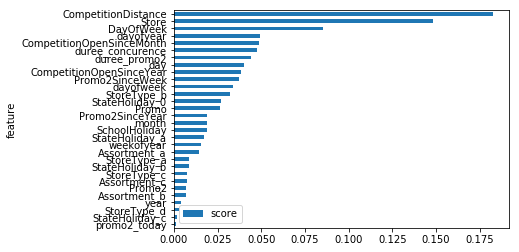

In [106]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
#Store in dataframe for plotting 
importance = pd.DataFrame(importance,columns = ['feature','score'])
#Make the score relative 
importance['score'] = importance['score']/importance['score'].sum()
importance.plot(kind ='barh' , x = 'feature' , y = 'score')

##### Training of the different algoritms

In [83]:
scores = []
scores_train = []

# iterate over classifiers
for clf, name in zip(regressors, names_regressors):
    print (name)
    if(name != "XGBoost"):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_validation)
        y_pred_train = clf.predict(X_train)
        score_train = rmspe(y_pred_train, y_train.values)
        score = rmspe(y_pred, y_validation.values)
        print("\t Score (trainning):", score_train, "\n")
        print("\t Score (testing):", score, "\n")
    else:
        train_probs = model.predict(xgb.DMatrix(X_train))
        test_probs = model.predict(xgb.DMatrix(X_validation))
        score_train = rmspe(np.exp(get_prob(train_probs))-1, y_train.values)
        score = rmspe(np.exp(get_prob(test_probs)) - 1, y_validation.values)
        print("\t Score (trainning):", score_train)
        print("\t Score (testing):", score)
    scores.append(score)
    scores_train.append(score_train)


DecisionTreeClassifier
	 Score (trainning): 0.0 

	 Score (testing): 0.18662168396 

RandomForestClassifier
	 Score (trainning): 0.0965440347756 

	 Score (testing): 0.151723866325 

ExtraTreesClassifier
	 Score (trainning): 1.27153240897e-05 

	 Score (testing): 0.154686439779 



##### Plot the different scores

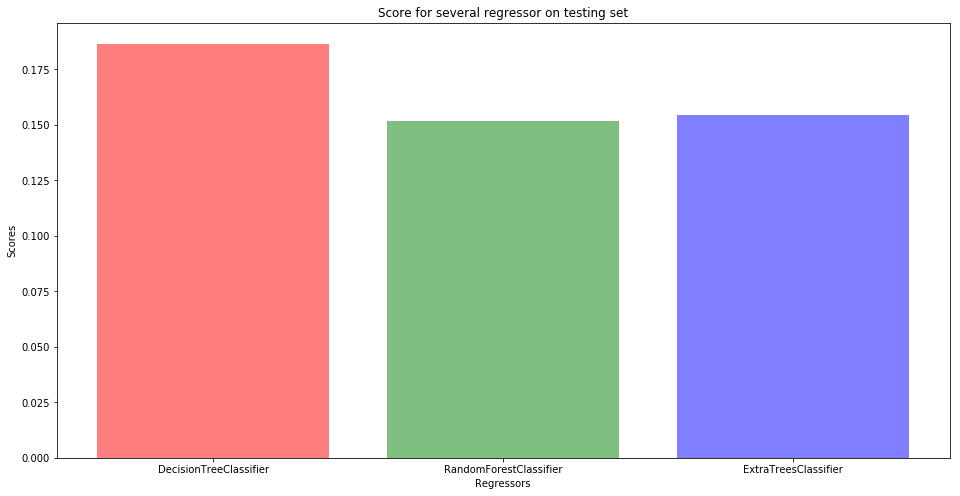

In [84]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on testing set")
plt.show()

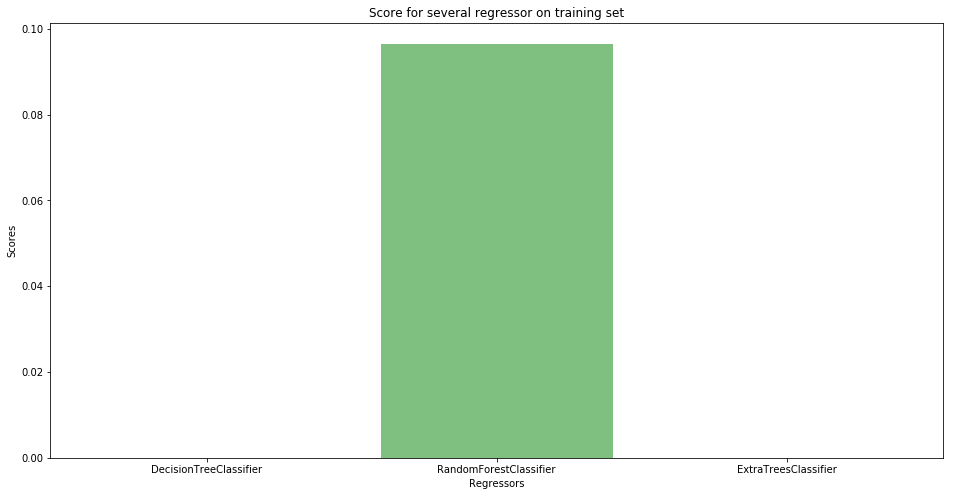

In [85]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores_train, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on training set")
plt.show()

# Training with GridSearch Strategy

##### Definition of the algorithm and theirs parameters for the grid search

In [ ]:
names_regressors = ['RandomForestRegressor']
names_regressors_tunedParams = [
    ["RandomForestRegressor", RandomForestRegressor(), {"max_depth": [3, 5], "bootstrap": [True, False]}]
]

##### Training of the different algoritms

In [ ]:
scores_regressors_cv = []
for name, regressor, tunedParam in names_regressors_tunedParams:
    clf = GridSearchCV(regressor, tunedParam)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validation)
    score = rmspe(y_pred, y_validation.values)

    print("\t Score:", score, "\n")
    
    print(name, "Best parameters :", clf.best_params_, "Accuracy:", score)
    scores_regressors_cv.append(score)

##### Plot the different scores

In [ ]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores_regressors_cv))
plt.bar(x, scores_regressors_cv, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracies for several classifiers")
plt.show()

# Naive Approach

In [86]:
class Naive:
    
    def same_day(self,day1,day2):
        """Return true if day1 and day 2 are the same day juste different year"""
        return (day1.day == day2.day) and (day1.month ==day2.month)
    
    def train(self,data,target):
        #Compute the mean aggregate by Days
        X = pd.concat([data['Date'].copy() , target.copy()],axis=1)
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        self.aggregate = X.groupby(['Date']).mean().reset_index()

    def predict(self,X): 
        X = X.copy()
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        # Merge with the aggregate
        pred = pd.merge(pd.DataFrame(X['Date']), self.aggregate, left_on='Date', right_on='Date')
        return np.array(pred['Sales'])

In [87]:
naive_model = Naive()
naive_model.train(Train,Train['Sales'])

y_train_pred = naive_model.predict(Train)
y_valid_pred = naive_model.predict(Validation)

print('Error on training set ', rmspe(y_train_pred, y_train.values))
print('Error on testing set ', rmspe(y_valid_pred, y_validation.values))

Error on training set  0.545173201048
Error on testing set  0.536137228672


In [88]:
#Evalueate it on the kaggle dataset
naive_model = Naive()
naive_model.train(train,train['Sales'])
prediction = naive_model.predict(test)
indic = test['Id']
res = pd.DataFrame(indic)
res['Sales'] = prediction
res.to_csv('data/submission_naive.csv', index = False)

L'approche naive fait 0.54591 sur Kaggle 

# Evaluation